### Subsetting sensitivities, training on GPU and GP Regression with LOVE

This notebook will look at a couple topics. First, it will run the exact GP method for GPU on a subset of the data. Next, it will try to implement a fast GP regression with LOVE, and examine the accuracy and efficiency for that. Finally, as these examples are built on subsetted portions of a full dataset, I will aim to examine the impact on efficiency/accuracy of subsetted data size.

### Setting up the environment and loading in the data

Adapted from [here](https://discuss.pytorch.org/t/dataloader-parallelization-synchronization-with-zarr-xarray-dask/176149).

In [1]:
!pip install torch tqdm gpytorch
!pip install xbatcher

In [2]:
import numpy as np
import gpytorch
import xarray as xr
import xbatcher
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import math
import matplotlib.pyplot as plt

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43471")
client

<Client: 'tcp://127.0.0.1:43471' processes=4 threads=4, memory=15.33 GiB>

In [4]:
# Open the dataset
baker_url = 's3://petrichor/geosmart/baker.zarr/'
baker_ds = xr.open_dataset(
    baker_url, chunks='auto', engine='zarr', storage_options={"anon": True}
)

In [5]:
baker_ds

<xarray.Dataset>
Dimensions:      (time: 55, y: 12089, x: 11383)
Coordinates:
  * time         (time) datetime64[ns] 1947-09-14 1950-09-02 ... 2020-12-12
  * x            (x) float64 5.809e+05 5.809e+05 ... 5.923e+05 5.923e+05
  * y            (y) float64 5.409e+06 5.409e+06 ... 5.397e+06 5.397e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(55, 712, 670), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    crs:            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS...
    scale_factor:   1.0

In [6]:
bgen = iter(xbatcher.BatchGenerator(baker_ds, {"x": 50, "y": 50, "time": 55}))
chunk = next(bgen)

We are now at a state where the dataset is in chunks

### Train model with the tensor

Copied from [here](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html)

In [7]:
# Creating generate test data
#max_elem_count = 10000
df = chunk.band1.to_dataframe().dropna().reset_index()
df['time'] = (df['time'] - df['time'].min())  / np.timedelta64(1,'D')
df_numpy = df.to_numpy(dtype=np.float64)

X_train = torch.from_numpy(df_numpy[0:10000,:-1]/np.mean(df_numpy[0:10000,:-1])).float()
Y_train = torch.from_numpy(df_numpy[0:10000,-1]/np.mean(df_numpy[0:10000,-1])).float()
X_test = torch.from_numpy(df_numpy[10000:12000,:-1]/np.mean(df_numpy[10000:12000,:-1])).float()
Y_test = torch.from_numpy(df_numpy[10000:12000,-1]/np.mean(df_numpy[10000:12000,-1])).float()
#chunk_sparse = np.random.choice(range(len(Y)), max_elem_count, replace=False)

#X_train,Y_train,X_test,Y_test

In [8]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#X_train,Y_train,X_test,Y_test = generate_tensor(chunk)
model = ExactGPModel(X_train.cuda(), Y_train.cuda(), likelihood.cuda())

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [10]:
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model.cuda())

training_iter = 50

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_train.cuda())
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train.cuda())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.736   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.700   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.663   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.625   lengthscale: 0.852   noise: 0.554
Iter 5/50 - Loss: 0.586   lengthscale: 0.907   noise: 0.513
Iter 6/50 - Loss: 0.546   lengthscale: 0.961   noise: 0.474
Iter 7/50 - Loss: 0.506   lengthscale: 1.011   noise: 0.437
Iter 8/50 - Loss: 0.465   lengthscale: 1.053   noise: 0.403
Iter 9/50 - Loss: 0.423   lengthscale: 1.083   noise: 0.370
Iter 10/50 - Loss: 0.381   lengthscale: 1.100   noise: 0.340
Iter 11/50 - Loss: 0.337   lengthscale: 1.103   noise: 0.312
Iter 12/50 - Loss: 0.293   lengthscale: 1.092   noise: 0.286
Iter 13/50 - Loss: 0.249   lengthscale: 1.068   noise: 0.261
Iter 14/50 - Loss: 0.204   lengthscale: 1.034   noise: 0.239
Iter 15/50 - Loss: 0.158   lengthscale: 0.992   noise: 0.218
Iter 16/50 - Loss: 0.112   lengthscale: 0.944   noise: 0.199
Iter 17/50 - Loss: 0.065   length

/srv/conda/envs/notebook/lib/python3.11/site-packages/linear_operator/operators/added_diag_linear_operator.py:128: NumericalWarning: NaNs encountered in preconditioner computation. Attempting to continue without preconditioning.
  warnings.warn(


Iter 27/50 - Loss: -0.425   lengthscale: 0.400   noise: 0.068
Iter 28/50 - Loss: -0.476   lengthscale: 0.361   noise: 0.061
Iter 29/50 - Loss: -0.527   lengthscale: 0.326   noise: 0.055
Iter 30/50 - Loss: -0.578   lengthscale: 0.294   noise: 0.050
Iter 31/50 - Loss: -0.629   lengthscale: 0.265   noise: 0.045
Iter 32/50 - Loss: -0.680   lengthscale: 0.240   noise: 0.041
Iter 33/50 - Loss: -0.732   lengthscale: 0.218   noise: 0.037
Iter 34/50 - Loss: -0.783   lengthscale: 0.200   noise: 0.033
Iter 35/50 - Loss: -0.835   lengthscale: 0.185   noise: 0.030
Iter 36/50 - Loss: -0.886   lengthscale: 0.172   noise: 0.027
Iter 37/50 - Loss: -0.938   lengthscale: 0.162   noise: 0.024
Iter 38/50 - Loss: -0.989   lengthscale: 0.153   noise: 0.022
Iter 39/50 - Loss: -1.041   lengthscale: 0.148   noise: 0.020
Iter 40/50 - Loss: -1.093   lengthscale: 0.144   noise: 0.018
Iter 41/50 - Loss: -1.144   lengthscale: 0.140   noise: 0.016
Iter 42/50 - Loss: -1.196   lengthscale: 0.137   noise: 0.014
Iter 43/

/srv/conda/envs/notebook/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iter 49/50 - Loss: -1.551   lengthscale: 0.104   noise: 0.007
Iter 50/50 - Loss: -1.601   lengthscale: 0.098   noise: 0.006


In [12]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test.cuda()))

In [13]:
observed_pred.mean.cpu()

tensor([0.9958, 0.9958, 0.9958,  ..., 0.9957, 0.9957, 0.9957])

Text(0, 0.5, 'Predicted elevation [m]')

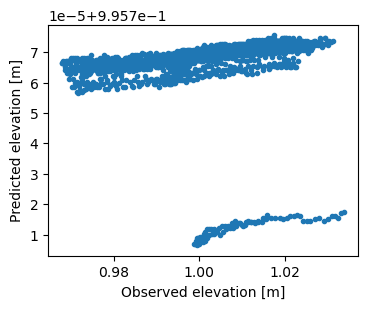

In [14]:
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(Y_test.numpy(),observed_pred.mean.cpu().numpy(),linestyle='None',marker='.')
#ax.plot([650,1000],[650,1000])
#ax.set_xlim([650,1000])
#ax.set_ylim([500,1000])
ax.set_xlabel('Observed elevation [m]')
ax.set_ylabel('Predicted elevation [m]')

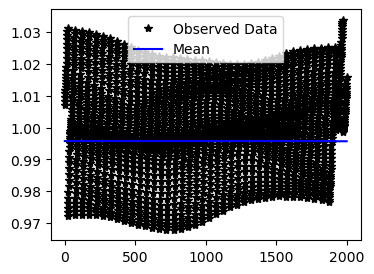

In [15]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot( Y_test.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])